In [1]:
import copy
import random
import traceback
import itertools
import collections


import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

from tqdm.autonotebook import tqdm

In [2]:
def init_random_seed(value=0):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True


init_random_seed()

Загрузка основных данных.

In [3]:
train_data_path = '../data/raw/passwords.csv'
train_data = pd.read_csv(train_data_path)
train_data.head()

,password,strength
0,yrtzuab476,1
1,yEdnN9jc1NgzkkBP,2
2,sarita99,1
3,Suramerica2015,2
4,PPRbMvDIxMQ19TMo,2


Загрузка дополнительного набора данных, который будет использоваться в качестве тестового набора данных. При обучении модели эти данные не используются.

In [4]:
all_data_path = '../data/external/data.csv'
pass_data = pd.read_csv(all_data_path, sep='\t')
d = {'password': pass_data['password,strength'].str[:-2].values,
     'strength': pass_data['password,strength'].str[-1].values.astype(int)}
pass_data = pd.DataFrame(data=d)

In [5]:
assert (pass_data.isna().sum().values == 0).all()
assert (train_data.isna().sum().values == 0).all()

### 1. Quick EDA

In [6]:
def entropy(password):
    _, cnt = np.unique(np.array(list(password)), return_counts=True)
    p = cnt / np.sum(cnt)
    H = -np.sum(p * np.log2(p))
    return H

In [7]:
train_data['entropy'] = train_data['password'].apply(entropy)

In [8]:
train_data.groupby('strength')['entropy'].describe()

,count,mean,std,min,25%,50%,75%,max
strength,,,,,,,,
0,13428.0,2.456393,0.357660,-0.000000,2.251629,2.521641,2.807355,2.807355
1,74278.0,2.944374,0.317679,0.773228,2.750000,2.947703,3.169925,3.700440
2,12294.0,3.699346,0.216719,2.378783,3.577820,3.750000,3.875000,4.897300


In [9]:
train_data.loc[train_data.entropy == 0]

,password,strength,entropy
12708,M,0,-0.0
46706,1,0,-0.0
52515,000000,0,-0.0
67897,______,0,-0.0
73253,9,0,-0.0
85724,@@@@@@@,0,-0.0


array([[<Axes: title={'center': 'strength'}>,
        <Axes: title={'center': 'entropy'}>]], dtype=object)

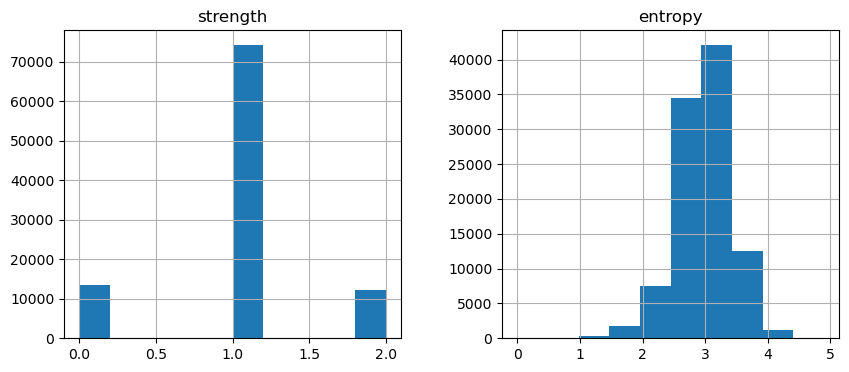

In [10]:
train_data.hist(figsize=(10, 4))

### 2. Feature engineering, tokenization of passwords, creating a dataset

Модель основана на NLP подходе. В качестве признаков будут использоваться значения энтропии (_H_) для каждого пароля, информация о длине строки пароля, а также токенизированный текст самого пароля.

Определение [энтропии](https://ru.wikipedia.org/wiki/%D0%98%D0%BD%D1%84%D0%BE%D1%80%D0%BC%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F_%D1%8D%D0%BD%D1%82%D1%80%D0%BE%D0%BF%D0%B8%D1%8F) с помощью собственной информации:
$$H = -\sum_{i=0}^{N}p_{i}*log_2(p_i)$$

In [11]:
train_data['len'] = train_data['password'].apply(len)
train_data['entropy'] = train_data['password'].apply(entropy)

Для кодирования пароля будет использоваться расширенный словарь, сформированный из символов тестовых данных. Помимо этого, словарь расширяется символами кириллицы и двумя функциональными символами:

`'pad: 0'` - используется в качестве заполнителя для NLP составляющей модели,  
`'unk_char: 1'` - используется для кодирования неизвестных символов.

In [12]:
MAX_TOKEN_LEN = 256

cyrillic_symb = 'АаБбВвГгДдЕеЁёЖжЗзИиЙйКкЛлМмНнОоПпСсТтУуФфХхЦцЧчШшЩщЪъЫыЬьЭэЮюЯя'
str_pass_data = itertools.chain.from_iterable(np.append(pass_data["password"], cyrillic_symb))
sorted_char_counts = dict(collections.Counter(str_pass_data).most_common())
sorted_char_counts = dict([('pad', 0), ('unk_char', 1)] + list(sorted_char_counts.items()))
char2id_dict = {char: i for i, (char, _) in enumerate(sorted_char_counts.items())}

In [13]:
print(f'Размер словаря: {len(char2id_dict)} символов')

Размер словаря: 267 символов


Каждый пароль разбивается на отдельные символы, которые кодируются при помощи словаря. Далее токенизированный пароль дополняется одним нулем слева и двумя нулями справа для обозначения начала-конца слова. Пароли, длина которых меньше максимально разрешенной (`MAX_TOKEN_LEN`), дополняются нулями справа. Для паролей, которые превосходят максимально разрешенную длину (`MAX_TOKEN_LEN`), производится срез, после чего они аналогично дополняются нулями.

После токенизации к каждому паролю добавляются значения его энтропии и длины (в порядке `entropy-len-tokenized_pass`). Это необходимо для внесения дополнительной информации о структуре пароля. Необходимость использования двух дополнительных признаков (`entropy-len`) обусловлена ограниченностью модели в возможности увидеть очень длинный пароль целиком, т.к. такой пароль будет обрезан. Можно сказать, что потеря информации компенсируется данными о длине и энтропии пароля.

In [14]:
def character_tokenizer(txt):
    return list(txt)


def tokenize_corpus(texts, tokenizer=character_tokenizer):
    return [tokenizer(text) for text in texts]


def char2id_pad(password, char2id_dict, max_token_len):
    vectorized = []
    for char in password:
        vectorized_char = char2id_dict.get(char, 1)
        vectorized.append(vectorized_char)
    if len(vectorized) <= max_token_len:
        return np.pad(vectorized, (1, max_token_len-len(vectorized)+2))
    else:
        return np.pad(vectorized[:max_token_len], (1, 2))

In [15]:
train_char_tokenized = tokenize_corpus(train_data['password'].values, tokenizer=character_tokenizer)
train_inputs = [char2id_pad(password, char2id_dict, MAX_TOKEN_LEN) for password in train_char_tokenized]
train_inputs = np.concatenate((train_data['entropy'].values.reshape(-1, 1),
                               train_data['len'].values.reshape(-1, 1),
                               train_inputs), axis=1)
train_labels = train_data['strength'].values

train_inputs = torch.tensor(train_inputs, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.long)

In [16]:
print(f'Каждый пароль интерпретирован {train_inputs.shape[1]} признаком')

Каждый пароль интерпретирован 261 признаком


Набор предоставляемых данных разбивается на обучающий и валидационный для отслеживания метрик оценивания качества модели.

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(train_inputs, train_labels, test_size=0.33)
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)

### 3. Model training

Модель (`POSLikeModel`) представляет собой классификатор, который состоит из двух частей.

Первая часть - (`main_head`) представляет собой анализатор структуры пароля. Признаки, представляющие собой токенизированный текст пароля, передаются в сверточный модуль (`backbone`), который заимствует идею skip connection в ResNet. Идея skip connection в данном случае используется не только для решения проблемы исчезающего градиента, но и позволяет учитывать локальный контекст в токене. Сверточный модуль рассматривает все возможные n-граммы символов, т.к. skip connection пробрасывает информацию о n-грамме в глубь сети (например, если использовать `kernal_size=3` и `layers_n=3`, то первый блок учитывает 3-граммы, второй блок - 5-граммы, а третий блок 7-граммы, при этом информация о 3-граммах не теряется и пробрасывается до последнего слоя).

Вторая часть - (`second_head`) извлекает дополнительную информацию для локального контекста из значений энтропии и длины символов пароля. Как указывалось ранее, такая информация расширяет ограниченный функционал модели. Можно сказать, что потерянная информация о символах пароля, которые сеть не увидела, извлекается из данных об энтропии и длине этого пароля. 

В конце результат двух блоков (`main_head, second_head`) конкатенируются и передаются в линейный слой - классификатор.

In [20]:
class SkipConnectionConv1d(nn.Module):
    def __init__(self, features_num, layers_n=1, kernel_size=3, conv_layer=nn.Conv1d, dropout=0.0):
        super().__init__()
        layers = []
        for _ in range(layers_n):
            layers.append(nn.Sequential(
                conv_layer(features_num, features_num, kernel_size, padding=kernel_size//2),
                nn.Dropout(dropout),
                nn.LeakyReLU()))
        self.layers = nn.ModuleList(layers)
    
    def forward(self, x):
        for layer in self.layers:
            x = x + layer(x)
        return x


class POSLikeModel(nn.Module):
    def __init__(self, vocab_size, target_num, embedding_size=32, **kwargs):
        super().__init__()
        self.char_embeddings = nn.Embedding(vocab_size, embedding_size, padding_idx=0)  # (142, 32)
        self.backbone = SkipConnectionConv1d(embedding_size, **kwargs)
        self.global_pooling = nn.AdaptiveMaxPool1d(1)
        self.main_head = nn.Sequential(nn.Linear(embedding_size, 3), nn.LeakyReLU())
        self.second_head = nn.Sequential(nn.Linear(2, 3), nn.LeakyReLU())
        self.out = nn.Linear(6, target_num)
        self.labels_num = target_num
    
    def forward(self, data):
        """data.shape - [BatchSize, Entropy+Len+MaxTokenLen+3]"""
        tokens = data[:, 2:].type(torch.long)
        H = data[:, :2]
        
        # используем эмбеддинг слой, для получения вектора каждого символа
        char_embeddings = self.char_embeddings(tokens)
        char_embeddings = char_embeddings.permute(0, 2, 1)

        # передаем вектора в сверточный модуль, чтобы учесть локальный контекст
        features = self.backbone(char_embeddings)
        
        # агрегируем признаки символов
        global_features = self.global_pooling(features).squeeze(-1)
        
        # получаем информацию о структуре пароля из первого dense слоя
        main_out = self.main_head(global_features)

        # получаем дополнительную информацию о структуре пароля из второго dense слоя
        second_out = self.second_head(H)

        # конкатенируемся и классифицируемся
        result = torch.cat((main_out, second_out), 1)
        logits = self.out(result)


        return logits

Так как задача представляет собой многоклассовую классификацию с неравномерным распределением, то в качестве метрики для оценивания результата выбрана [F1 мера или F1 score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) - среднее гармоническое точности (precision) и полноты (recall). Эта метрика учитывает ошибки первого и второго рода. 

$$F1=2*\frac{PRE*REC}{PRE+REC}$$
$$PRE=\frac{TP}{TP+FP}$$
$$REC=\frac{TP}{P}=\frac{TP}{FN+TP} $$

Функция потерь (loss function) - кросс-энтропия.  
Также представлена возможность использовать планировщик скорости обучения сети.

In [22]:
def train_eval_loop(model, train_dataset, val_dataset, criterion,
                    lr=1e-4, epoch_n=10, batch_size=64,
                    device=None, early_stopping_patience=10, l2_reg_alpha=0,
                    optimizer_ctor=None, lr_scheduler_ctor=None,
                    shuffle_train=True, dataloader_workers_n=0):
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(device)
    model.to(device)

    if optimizer_ctor is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg_alpha)
    else:
        optimizer = optimizer_ctor(model.parameters(), lr=lr)

    if lr_scheduler_ctor is not None:
        lr_scheduler = lr_scheduler_ctor(optimizer)
    else:
        lr_scheduler = None

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle_train,
                                  num_workers=dataloader_workers_n)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                                num_workers=dataloader_workers_n)

    best_val_loss = float('inf')
    best_epoch_i = 0
    best_model = copy.deepcopy(model)

    for epoch_i in (pbar := tqdm(range(epoch_n))):
        try:
            model.train()
            mean_train_loss = 0
            train_batches_n = 0
            for batch_x, batch_y in train_dataloader:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)

                pred = model(batch_x)
                loss = criterion(pred, batch_y)

                model.zero_grad()
                loss.backward()

                optimizer.step()

                mean_train_loss += float(loss)
                train_batches_n += 1

            mean_train_loss /= train_batches_n
            print(f'\nEpoch: {epoch_i}, mean train loss: {mean_train_loss}')

            model.eval()
            mean_val_loss = 0
            mean_f1_score = 0
            val_batches_n = 0

            with torch.no_grad():
                for batch_x, batch_y in val_dataloader:
                    batch_x = batch_x.to(device)
                    batch_y = batch_y.to(device)

                    pred = model(batch_x)
                    loss = criterion(pred, batch_y)

                    mean_val_loss += float(loss)
                    val_batches_n += 1
                    mean_f1_score += f1_score(batch_y.detach().cpu().numpy(),
                                              pred.argmax(1).detach().cpu().numpy(),
                                              average='macro')

            mean_f1_score /= val_batches_n
            mean_val_loss /= val_batches_n
            print(f'Epoch: {epoch_i}, mean val loss: {mean_val_loss}')

            if mean_val_loss < best_val_loss:
                best_epoch_i = epoch_i
                best_val_loss = mean_val_loss
                best_model = copy.deepcopy(model)
                print('The new best model')
            elif epoch_i - best_epoch_i > early_stopping_patience:
                print(f'Early stopping')
                break

            if lr_scheduler is not None:
                lr_scheduler.step(mean_val_loss)
                
            pbar.set_description(f'Epoch: {epoch_i}')
            pbar.set_postfix_str(f'Val F1 score: {mean_f1_score: .3f}, Val Loss: {mean_val_loss: .3f}')
        except KeyboardInterrupt:
            print('[Stopped]')
            break
        except Exception as ex:
            print(f'Train exception: {ex}\n{traceback.format_exc()}')
            break

    return best_val_loss, best_model

In [29]:
scheduler = lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=2,
                                                                     factor=0.5,
                                                                     verbose=True)

model = POSLikeModel(vocab_size=len(sorted_char_counts), target_num=3,
                     embedding_size=24, layers_n=3, kernel_size=3, dropout=0.0)
print('Количество параметров', sum(np.product(t.shape) for t in model.parameters()))

(best_val_loss, best_model) = train_eval_loop(model,
                                              train_dataset,
                                              valid_dataset,
                                              F.cross_entropy,
                                              lr=3e-3,
                                              epoch_n=10,
                                              batch_size=32,
                                              device='cuda',
                                              early_stopping_patience=5,
                                              lr_scheduler_ctor=scheduler)

Количество параметров 11769


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 0, mean train loss: 0.2418685429440429
Epoch: 0, mean val loss: 0.07225222543401774
The new best model

Epoch: 1, mean train loss: 0.03664268394951053
Epoch: 1, mean val loss: 0.0193878256233252
The new best model

Epoch: 2, mean train loss: 0.017240029574644176
Epoch: 2, mean val loss: 0.015846238322981578
The new best model

Epoch: 3, mean train loss: 0.011663673649962441
Epoch: 3, mean val loss: 0.01213314857291117
The new best model

Epoch: 4, mean train loss: 0.009313776443789468
Epoch: 4, mean val loss: 0.011736424421847252
The new best model

Epoch: 5, mean train loss: 0.00704024061214519
Epoch: 5, mean val loss: 0.02102604645231238

Epoch: 6, mean train loss: 0.006799664055708113
Epoch: 6, mean val loss: 0.00915046837168268
The new best model

Epoch: 7, mean train loss: 0.006694913936180125
Epoch: 7, mean val loss: 0.007662669633802135
The new best model

Epoch: 8, mean train loss: 0.005728594370851203
Epoch: 8, mean val loss: 0.00404479752382905
The new best model

Epo

In [30]:
best_val_loss

0.003848491349129805

### 4. Model evaluation

Модель отлично предсказывает тренировочный, валидационный и тестовый датасет.

In [31]:
def predict_with_model(model, dataset, device=None, batch_size=32, num_workers=0):
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    results_by_batch = []

    device = torch.device(device)
    model.to(device)
    model.eval()

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    with torch.no_grad():
        for batch_x, _ in tqdm(dataloader, total=len(dataset)/batch_size):
            batch_x = batch_x.to(device)
            batch_pred = model(batch_x)
            results_by_batch.append(batch_pred.detach().cpu().numpy())
        return np.concatenate(results_by_batch, 0)

In [32]:
train_pred = predict_with_model(best_model, train_dataset)
train_loss = F.cross_entropy(torch.tensor(train_pred),
                             y_train)
print('Среднее значение функции потерь на обучении', float(train_loss))
print(classification_report(y_train, train_pred.argmax(1)))
print()

valid_pred = predict_with_model(best_model, valid_dataset)
valid_loss = F.cross_entropy(torch.tensor(valid_pred),
                             y_valid)
print('Среднее значение функции потерь на валидации', float(valid_loss))
print(classification_report(y_valid, valid_pred.argmax(1)))

  0%|          | 0/2093.75 [00:00<?, ?it/s]

Среднее значение функции потерь на обучении 0.0016209165332838893
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8979
           1       1.00      1.00      1.00     49760
           2       1.00      1.00      1.00      8261

    accuracy                           1.00     67000
   macro avg       1.00      1.00      1.00     67000
weighted avg       1.00      1.00      1.00     67000




  0%|          | 0/1031.25 [00:00<?, ?it/s]

Среднее значение функции потерь на валидации 0.003838973818346858
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4449
           1       1.00      1.00      1.00     24518
           2       1.00      1.00      1.00      4033

    accuracy                           1.00     33000
   macro avg       1.00      1.00      1.00     33000
weighted avg       1.00      1.00      1.00     33000



Для проверки новых паролей реализована функция для обработки данных.

In [38]:
def create_input_dataset(data, max_token_len=256, tokenizer=character_tokenizer, ttsplit=False):
    data['len'] = data['password'].apply(len)
    data['entropy'] = data['password'].apply(entropy)

    char_tokenized = tokenize_corpus(data['password'].values, tokenizer)
    inputs = [char2id_pad(password, char2id_dict, max_token_len) for password in char_tokenized]
    inputs = np.concatenate((data['entropy'].values.reshape(-1, 1),
                             data['len'].values.reshape(-1, 1),
                             inputs), axis=1)
    labels = data['strength'].values.astype(int)
    inputs = torch.tensor(inputs, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.long)
    if ttsplit:
        X_train, X_valid, y_train, y_valid = train_test_split(inputs, labels, test_size=0.33)
        train_dataset = TensorDataset(X_train, y_train)
        valid_dataset = TensorDataset(X_valid, y_valid)
        return train_dataset, valid_dataset
    else:
        test_dataset = TensorDataset(inputs, labels)
        return test_dataset, labels

In [39]:
test_dataset, test_labels = create_input_dataset(pass_data, max_token_len=MAX_TOKEN_LEN,
                                                 tokenizer=character_tokenizer, ttsplit=False)

In [40]:
test_pred = predict_with_model(best_model, test_dataset)
test_loss = F.cross_entropy(torch.tensor(test_pred),
                            test_labels)
print('Среднее значение функции потерь на тесте', float(test_loss))
print(classification_report(test_labels, test_pred.argmax(1)))
print()

  0%|          | 0/20933.71875 [00:00<?, ?it/s]

Среднее значение функции потерь на тесте 0.0035367398522794247
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     89702
           1       1.00      1.00      1.00    496801
           2       1.00      1.00      1.00     83376

    accuracy                           1.00    669879
   macro avg       1.00      1.00      1.00    669879
weighted avg       1.00      1.00      1.00    669879




Можно заметить, что несмотря на небольшое количество параметров, модель отлично справляется и на новых данных.

In [42]:
passwords = np.array([('ac7d', 0),
                      ('абоба', 0),
                      ('HelloMy@favOr14092', 2),
                      ('Пушкин№КоЛотушк1н', 2)])
check_data = pd.DataFrame(passwords, columns=['password', 'strength'])

check_dataset, check_labels = create_input_dataset(check_data, max_token_len=MAX_TOKEN_LEN, tokenizer=character_tokenizer, ttsplit=False)

In [43]:
check_pred = predict_with_model(best_model, check_dataset)

  0%|          | 0/0.125 [00:00<?, ?it/s]

In [44]:
check_pred.argmax(1)

array([0, 0, 2, 2], dtype=int64)